## 1. Import Required Libraries

In [67]:
import requests
import pandas as pd
import numpy as np
import time
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("✓ Libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

✓ Libraries imported successfully!
Pandas version: 2.3.3
NumPy version: 2.2.6


## 2. Define Enhanced Data Fetching Functions

**Key improvements:**
- Properly iterates through ALL available historical data
- Handles API pagination correctly
- Validates we get the full 5 years (~1,825 days)

In [68]:
def fetch_kraken_ohlc(pair='XBTUSD', interval=1440, since=None):
    """
    Fetch OHLC data from Kraken API
    
    Parameters:
    - pair: Trading pair (XBTUSD for Bitcoin/USD)
    - interval: Time frame interval in minutes (1440 = 1 day)
    - since: Unix timestamp to fetch data from
    
    Returns:
    - tuple: (ohlc_data, last_timestamp)
    """
    url = 'https://api.kraken.com/0/public/OHLC'
    
    params = {
        'pair': pair,
        'interval': interval
    }
    
    if since:
        params['since'] = since
    
    try:
        response = requests.get(url, params=params, timeout=30)
        response.raise_for_status()
        data = response.json()
        
        if data.get('error') and len(data['error']) > 0:
            print(f"API Error: {data['error']}")
            return None, None
            
        # Extract the OHLC data
        result_keys = [k for k in data['result'].keys() if k != 'last']
        if not result_keys:
            print("No data in response")
            return None, None
            
        pair_data = data['result'][result_keys[0]]
        last_timestamp = data['result']['last']
        
        return pair_data, last_timestamp
        
    except requests.exceptions.RequestException as e:
        print(f"Request failed: {e}")
        return None, None
    except Exception as e:
        print(f"Unexpected error: {e}")
        return None, None

In [69]:
def fetch_all_historical_data(years=2):
    print(f"FETCHING {years} YEARS OF BITCOIN DAILY DATA FROM KRAKEN")
    print("="*70)
    
    # Calculate target date range
    end_date = datetime.now()
    start_date = end_date - timedelta(days=years*365)
    target_start_timestamp = int(start_date.timestamp())
    
    print(f"Target date range:")
    print(f"  Start: {start_date.strftime('%Y-%m-%d')}")
    print(f"  End:   {end_date.strftime('%Y-%m-%d')}")
    print(f"  Expected records: ~{years * 365} days\n")
    
    all_data = []
    since = target_start_timestamp
    iteration = 0
    max_iterations = 20  
    
    print("Fetching data...\n")
    
    while iteration < max_iterations:
        iteration += 1
        
        # Fetch batch
        ohlc_data, last_timestamp = fetch_kraken_ohlc(since=since)
        
        if ohlc_data is None:
            print(f"\n❌ Batch {iteration}: Failed to fetch data")
            break
        
        # Add to collection
        batch_size = len(ohlc_data)
        all_data.extend(ohlc_data)
        
        # Calculate batch date range
        if batch_size > 0:
            batch_start_date = datetime.fromtimestamp(ohlc_data[0][0]).strftime('%Y-%m-%d')
            batch_end_date = datetime.fromtimestamp(ohlc_data[-1][0]).strftime('%Y-%m-%d')
            print(f"Batch {iteration:2d}: {batch_start_date} to {batch_end_date} | "
                  f"Got {batch_size:4d} records | Total: {len(all_data):5d}")
        
        # Check if we've fetched all available data
        if last_timestamp == since:
            print(f"\n✓ No more data available (last_timestamp == since)")
            break
        
        # Check if we got less than expected (end of available data)
        if batch_size < 100:  # Lowered threshold
            print(f"\n✓ Reached end of available data (batch_size < 100)")
            break
        
        # Update since for next iteration
        since = last_timestamp
        
        # Be respectful to API - add delay
        time.sleep(2)
    
    print("\n" + "="*70)
    print(f"DATA COLLECTION COMPLETE (KRAKEN)")
    print("="*70)
    print(f"Total records fetched: {len(all_data)}")
    print(f"Expected for {years} years: ~{years * 365}")
    
    if len(all_data) >= years * 365 * 0.9:
        print(f"\n✅ SUCCESS! Got {len(all_data)} days (Expected: ~{years * 365})")
    else:
        print(f"\n⚠️  Got {len(all_data)} days (Expected: ~{years * 365})")
    
    return all_data

## 3. Multiple Data Sources for Full 5 Years

**We'll try multiple APIs to ensure we get complete 5-year data!**

In [70]:
def fetch_coingecko_ohlc(days=365):
    print(f"Fetching {days} days from CoinGecko OHLC endpoint...")
    
    url = 'https://api.coingecko.com/api/v3/coins/bitcoin/ohlc'
    
    params = {
        'vs_currency': 'usd',
        'days': days
    }
    
    try:
        response = requests.get(url, params=params, timeout=60)
        response.raise_for_status()
        data = response.json()
        
        if isinstance(data, dict) and 'error' in data:
            print(f"❌ API Error: {data}")
            return None
        
        # Data format: [[timestamp, open, high, low, close], ...]
        df = pd.DataFrame(data, columns=['timestamp', 'open', 'high', 'low', 'close'])
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        
        print(f"✓ Got {len(df)} records from {df['timestamp'].min().date()} to {df['timestamp'].max().date()}")
        
        return df
        
    except Exception as e:
        print(f"❌ Error: {e}")
        return None

In [71]:
def fetch_yahoo_finance(years=2):
    print("="*70)
    print(f"FETCHING {years} YEARS FROM YAHOO FINANCE (RECOMMENDED)")
    print("="*70)
    
    try:
        # Try importing yfinance
        try:
            import yfinance as yf
        except ImportError:
            print("Installing yfinance...")
            import subprocess
            import sys
            subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'yfinance', '-q'])
            import yfinance as yf
            print("✓ yfinance installed\n")
        
        # Calculate date range
        end_date = datetime.now()
        start_date = end_date - timedelta(days=years*365 + 10)  # Add buffer
        
        print(f"Downloading BTC-USD from {start_date.date()} to {end_date.date()}...")
        print("Please wait, this may take 10-30 seconds...\n")
        
        # Download data
        btc = yf.download('BTC-USD', start=start_date, end=end_date, interval='1d', progress=False)
        
        if btc.empty:
            print("❌ No data received")
            return None
        
        # Process data
        df = btc.reset_index()
        df = df.rename(columns={
            'Date': 'timestamp',
            'Open': 'open',
            'High': 'high',
            'Low': 'low',
            'Close': 'close',
            'Volume': 'volume'
        })
        
        # Keep only needed columns
        df = df[['timestamp', 'open', 'high', 'low', 'close', 'volume']]
        
        # Sort and clean
        df = df.sort_values('timestamp').reset_index(drop=True)
        df = df.dropna(subset=['open', 'high', 'low', 'close'])
        
        print(f"✅ SUCCESS! Downloaded {len(df)} days of data")
        print(f"  Date range: {df['timestamp'].min().date()} to {df['timestamp'].max().date()}")
        print(f"  Days span: {(df['timestamp'].max() - df['timestamp'].min()).days} days\n")
        
        return df
        
    except Exception as e:
        print(f"❌ Error: {e}")
        import traceback
        traceback.print_exc()
        return None

In [72]:
def fetch_multiple_years_coingecko(years=2):
    print("="*70)
    print(f"FETCHING {years} YEARS FROM COINGECKO (MULTIPLE REQUESTS)")
    print("="*70)
    print("Note: This will make multiple API calls with delays\n")
    
    all_data = []
    
    # Fetch in 365-day chunks
    for i in range(years):
        days = 365 if i < years - 1 else 365
        print(f"\nRequest {i+1}/{years}: Fetching {days} days...")
        
        df = fetch_coingecko_ohlc(days=days)
        
        if df is not None and len(df) > 0:
            all_data.append(df)
            print(f"  Added {len(df)} records")
        else:
            print(f"  ⚠️  Failed to fetch chunk {i+1}")
        
        # Rate limiting - be nice to the API
        if i < years - 1:
            print("  Waiting 3 seconds...")
            time.sleep(3)
    
    if not all_data:
        print("\n❌ Failed to fetch any data from CoinGecko")
        return None
    
    # Combine all chunks
    df_combined = pd.concat(all_data, ignore_index=True)
    df_combined = df_combined.sort_values('timestamp').drop_duplicates(subset=['timestamp']).reset_index(drop=True)
    
    print(f"\n" + "="*70)
    print(f"✓ COMBINED DATA")
    print(f"="*70)
    print(f"Total records: {len(df_combined)}")
    print(f"Date range: {df_combined['timestamp'].min().date()} to {df_combined['timestamp'].max().date()}")
    print(f"Days span: {(df_combined['timestamp'].max() - df_combined['timestamp'].min()).days} days\n")
    
    return df_combined

## 4. Fetch Bitcoin Data - Try All Methods

**We'll try Yahoo Finance first (most reliable), then alternatives**

### Method 1: Yahoo Finance (RECOMMENDED - Most Reliable)

In [73]:
# Try Yahoo Finance first - most reliable
bitcoin_df_yahoo = fetch_yahoo_finance(years=2)

if bitcoin_df_yahoo is not None:
    print(f"✅ Yahoo Finance: {len(bitcoin_df_yahoo)} records")
else:
    print("❌ Yahoo Finance failed")

FETCHING 2 YEARS FROM YAHOO FINANCE (RECOMMENDED)
Please wait, this may take 10-30 seconds...

❌ Error: ['open', 'high', 'low', 'close']
❌ Yahoo Finance failed


Traceback (most recent call last):
  File "/var/folders/4b/rp4tyc6j1k9cmfntnbklpj8h0000gn/T/ipykernel_10043/1172805309.py", line 48, in fetch_yahoo_finance
    df = df.dropna(subset=['open', 'high', 'low', 'close'])
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/afrazrupak/tf_env/lib/python3.11/site-packages/pandas/core/frame.py", line 6692, in dropna
    raise KeyError(np.array(subset)[check].tolist())
KeyError: ['open', 'high', 'low', 'close']


### Method 2: Kraken API (Should work well for 2 years)

In [74]:
# Fetch from Kraken (backup)
raw_data_kraken = fetch_all_historical_data(years=2)

print(f"\nKraken data points: {len(raw_data_kraken)}")

FETCHING 2 YEARS OF BITCOIN DAILY DATA FROM KRAKEN
Target date range:
  Start: 2023-10-26
  End:   2025-10-25
  Expected records: ~730 days

Fetching data...

Batch  1: 2023-11-04 to 2025-10-24 | Got  721 records | Total:   721
Batch  2: 2025-10-23 to 2025-10-24 | Got    2 records | Total:   723

✓ No more data available (last_timestamp == since)

DATA COLLECTION COMPLETE (KRAKEN)
Total records fetched: 723
Expected for 2 years: ~730

✅ SUCCESS! Got 723 days (Expected: ~730)

Kraken data points: 723


### Method 3: CoinGecko (If Yahoo Finance failed)

In [75]:
# Only try CoinGecko if Yahoo failed
bitcoin_df_coingecko = None

if bitcoin_df_yahoo is None or len(bitcoin_df_yahoo) < 700:
    print("Yahoo Finance didn't provide enough data, trying CoinGecko...\n")
    bitcoin_df_coingecko = fetch_multiple_years_coingecko(years=2)
    
    if bitcoin_df_coingecko is not None:
        print(f"\n✅ CoinGecko: {len(bitcoin_df_coingecko)} records")
    else:
        print("\n❌ CoinGecko failed")
else:
    print("Yahoo Finance data looks good, skipping CoinGecko.")

Yahoo Finance didn't provide enough data, trying CoinGecko...

FETCHING 2 YEARS FROM COINGECKO (MULTIPLE REQUESTS)
Note: This will make multiple API calls with delays


Request 1/2: Fetching 365 days...
Fetching 365 days from CoinGecko OHLC endpoint...
✓ Got 92 records from 2024-10-24 to 2025-10-23
  Added 92 records
  Waiting 3 seconds...

Request 2/2: Fetching 365 days...
Fetching 365 days from CoinGecko OHLC endpoint...
✓ Got 92 records from 2024-10-24 to 2025-10-23
  Added 92 records

✓ COMBINED DATA
Total records: 92
Date range: 2024-10-24 to 2025-10-23
Days span: 364 days


✅ CoinGecko: 92 records


### Select the Best Dataset

In [76]:
# Choose the best data source
print("\n" + "="*70)
print("DATA SOURCE SELECTION")
print("="*70)

sources = []

if bitcoin_df_yahoo is not None:
    sources.append(('Yahoo Finance', bitcoin_df_yahoo))
    print(f"Yahoo Finance:  {len(bitcoin_df_yahoo):5d} records")

if bitcoin_df_coingecko is not None:
    sources.append(('CoinGecko', bitcoin_df_coingecko))
    print(f"CoinGecko:      {len(bitcoin_df_coingecko):5d} records")

if raw_data_kraken:
    sources.append(('Kraken', process_kraken_data(raw_data_kraken)))
    print(f"Kraken:         {len(raw_data_kraken):5d} records")

if not sources:
    raise Exception("❌ ALL DATA SOURCES FAILED! Check your internet connection.")

# Select source with most data
best_source_name, bitcoin_df_raw = max(sources, key=lambda x: len(x[1]))

print(f"\n✓ SELECTED: {best_source_name} ({len(bitcoin_df_raw)} records)")
print("="*70)


DATA SOURCE SELECTION
CoinGecko:         92 records
Kraken:           723 records

✓ SELECTED: Kraken (721 records)


## 5. Process the Data

In [77]:
def process_kraken_data(raw_data):
    """
    Process raw Kraken OHLC data into clean DataFrame
    """
    columns = ['timestamp', 'open', 'high', 'low', 'close', 'vwap', 'volume', 'count']
    df = pd.DataFrame(raw_data, columns=columns)
    
    # Convert types
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    for col in ['open', 'high', 'low', 'close', 'vwap', 'volume']:
        df[col] = df[col].astype(float)
    df['count'] = df['count'].astype(int)
    
    # Sort and remove duplicates
    df = df.sort_values('timestamp').reset_index(drop=True)
    df = df.drop_duplicates(subset=['timestamp'], keep='last')
    
    # Add assignment-required columns
    df['name'] = 'Bitcoin'
    df['timeOpen'] = df['timestamp']
    df['timeClose'] = df['timestamp']
    df['timeHigh'] = df['timestamp']
    df['timeLow'] = df['timestamp']
    df['marketCap'] = np.nan
    
    # Reorder columns
    final_columns = ['timeOpen', 'timeClose', 'timeHigh', 'timeLow', 'name',
                     'open', 'high', 'low', 'close', 'volume', 'marketCap', 'timestamp']
    df = df[final_columns]
    
    return df

In [78]:
# Process and standardize the data
print("\nProcessing and standardizing data...\n")

# Ensure all required columns exist
if 'volume' not in bitcoin_df_raw.columns:
    bitcoin_df_raw['volume'] = np.nan

# Add metadata columns
bitcoin_df_raw['name'] = 'Bitcoin'
bitcoin_df_raw['timeOpen'] = bitcoin_df_raw['timestamp']
bitcoin_df_raw['timeClose'] = bitcoin_df_raw['timestamp']
bitcoin_df_raw['timeHigh'] = bitcoin_df_raw['timestamp']
bitcoin_df_raw['timeLow'] = bitcoin_df_raw['timestamp']
bitcoin_df_raw['marketCap'] = np.nan

# Final column order
final_columns = ['timeOpen', 'timeClose', 'timeHigh', 'timeLow', 'name',
                 'open', 'high', 'low', 'close', 'volume', 'marketCap', 'timestamp']

bitcoin_df = bitcoin_df_raw[final_columns].copy()

print("="*70)
print("FINAL PROCESSED DATA")
print("="*70)
print(f"Data Source:   {best_source_name}")
print(f"Total records: {len(bitcoin_df)}")
print(f"Date range:    {bitcoin_df['timestamp'].min().date()} to {bitcoin_df['timestamp'].max().date()}")
print(f"Days span:     {(bitcoin_df['timestamp'].max() - bitcoin_df['timestamp'].min()).days} days")

# Verify we have enough data
if len(bitcoin_df) >= 700:
    print(f"\n✅ SUCCESS! Got {len(bitcoin_df)} days of data (Target: ~730 for 2 years)")
else:
    print(f"\n⚠️  WARNING: Only got {len(bitcoin_df)} days (Target: ~730)")


Processing and standardizing data...

FINAL PROCESSED DATA
Data Source:   Kraken
Total records: 721
Date range:    2023-11-04 to 2025-10-24
Days span:     720 days

✅ SUCCESS! Got 721 days of data (Target: ~730 for 2 years)


## 6. Data Quality Check

In [79]:
print("="*70)
print("DATA QUALITY REPORT")
print("="*70)

print("\n1. DataFrame Shape:")
print(f"   Rows: {bitcoin_df.shape[0]}")
print(f"   Columns: {bitcoin_df.shape[1]}")

print("\n2. Data Types:")
print(bitcoin_df.dtypes)

print("\n3. Missing Values:")
missing = bitcoin_df.isnull().sum()
print(missing)
print(f"\n   Total missing: {missing.sum()}")

print("\n4. First 5 Records:")
display(bitcoin_df.head())

print("\n5. Last 5 Records:")
display(bitcoin_df.tail())

print("\n6. Statistical Summary:")
display(bitcoin_df[['open', 'high', 'low', 'close', 'volume']].describe())

DATA QUALITY REPORT

1. DataFrame Shape:
   Rows: 721
   Columns: 12

2. Data Types:
timeOpen     datetime64[ns]
timeClose    datetime64[ns]
timeHigh     datetime64[ns]
timeLow      datetime64[ns]
name                 object
open                float64
high                float64
low                 float64
close               float64
volume              float64
marketCap           float64
timestamp    datetime64[ns]
dtype: object

3. Missing Values:
timeOpen       0
timeClose      0
timeHigh       0
timeLow        0
name           0
open           0
high           0
low            0
close          0
volume         0
marketCap    721
timestamp      0
dtype: int64

   Total missing: 721

4. First 5 Records:


,timeOpen,timeClose,timeHigh,timeLow,name,open,high,low,close,volume,marketCap,timestamp
0,2023-11-04,2023-11-04,2023-11-04,2023-11-04,Bitcoin,34741.2,35257.9,34614.4,35090.3,1617.412893,NaN,2023-11-04
1,2023-11-05,2023-11-05,2023-11-05,2023-11-05,Bitcoin,35091.1,35382.1,34520.1,35050.0,1827.875379,NaN,2023-11-05
2,2023-11-06,2023-11-06,2023-11-06,2023-11-06,Bitcoin,35050.1,35267.1,34767.3,35028.6,1572.808326,NaN,2023-11-06
3,2023-11-07,2023-11-07,2023-11-07,2023-11-07,Bitcoin,35028.6,35900.1,34560.0,35449.0,2573.312580,NaN,2023-11-07
4,2023-11-08,2023-11-08,2023-11-08,2023-11-08,Bitcoin,35449.1,36094.0,35100.0,35626.4,2554.528167,NaN,2023-11-08



5. Last 5 Records:


,timeOpen,timeClose,timeHigh,timeLow,name,open,high,low,close,volume,marketCap,timestamp
716,2025-10-20,2025-10-20,2025-10-20,2025-10-20,Bitcoin,108669.8,111700.1,107466.8,110574.4,2444.936091,NaN,2025-10-20
717,2025-10-21,2025-10-21,2025-10-21,2025-10-21,Bitcoin,110574.4,114000.0,107500.0,108406.1,2574.394839,NaN,2025-10-21
718,2025-10-22,2025-10-22,2025-10-22,2025-10-22,Bitcoin,108406.1,109156.4,106717.0,107644.1,2289.043050,NaN,2025-10-22
720,2025-10-23,2025-10-23,2025-10-23,2025-10-23,Bitcoin,107644.1,111296.0,107556.3,110080.0,1567.704060,NaN,2025-10-23
722,2025-10-24,2025-10-24,2025-10-24,2025-10-24,Bitcoin,110080.0,112400.0,109757.8,110796.1,1470.253905,NaN,2025-10-24



6. Statistical Summary:


,open,high,low,close,volume
count,721.000000,721.000000,721.000000,721.000000,721.000000
mean,79128.013454,80524.539528,77682.164771,79233.475867,2164.129797
std,24923.396407,25146.675809,24641.776009,24896.240662,1606.341844
min,34741.200000,35257.900000,34520.100000,35028.600000,162.629861
25%,60859.900000,62364.800000,59850.000000,60860.000000,1107.076020
50%,71306.700000,72662.000000,69600.000000,71371.200000,1750.127032
75%,102222.000000,104319.100000,100147.000000,102406.000000,2649.072801
max,124765.900000,126198.100000,123144.100000,124766.500000,10911.287735


## 7. Exploratory Data Analysis (EDA)

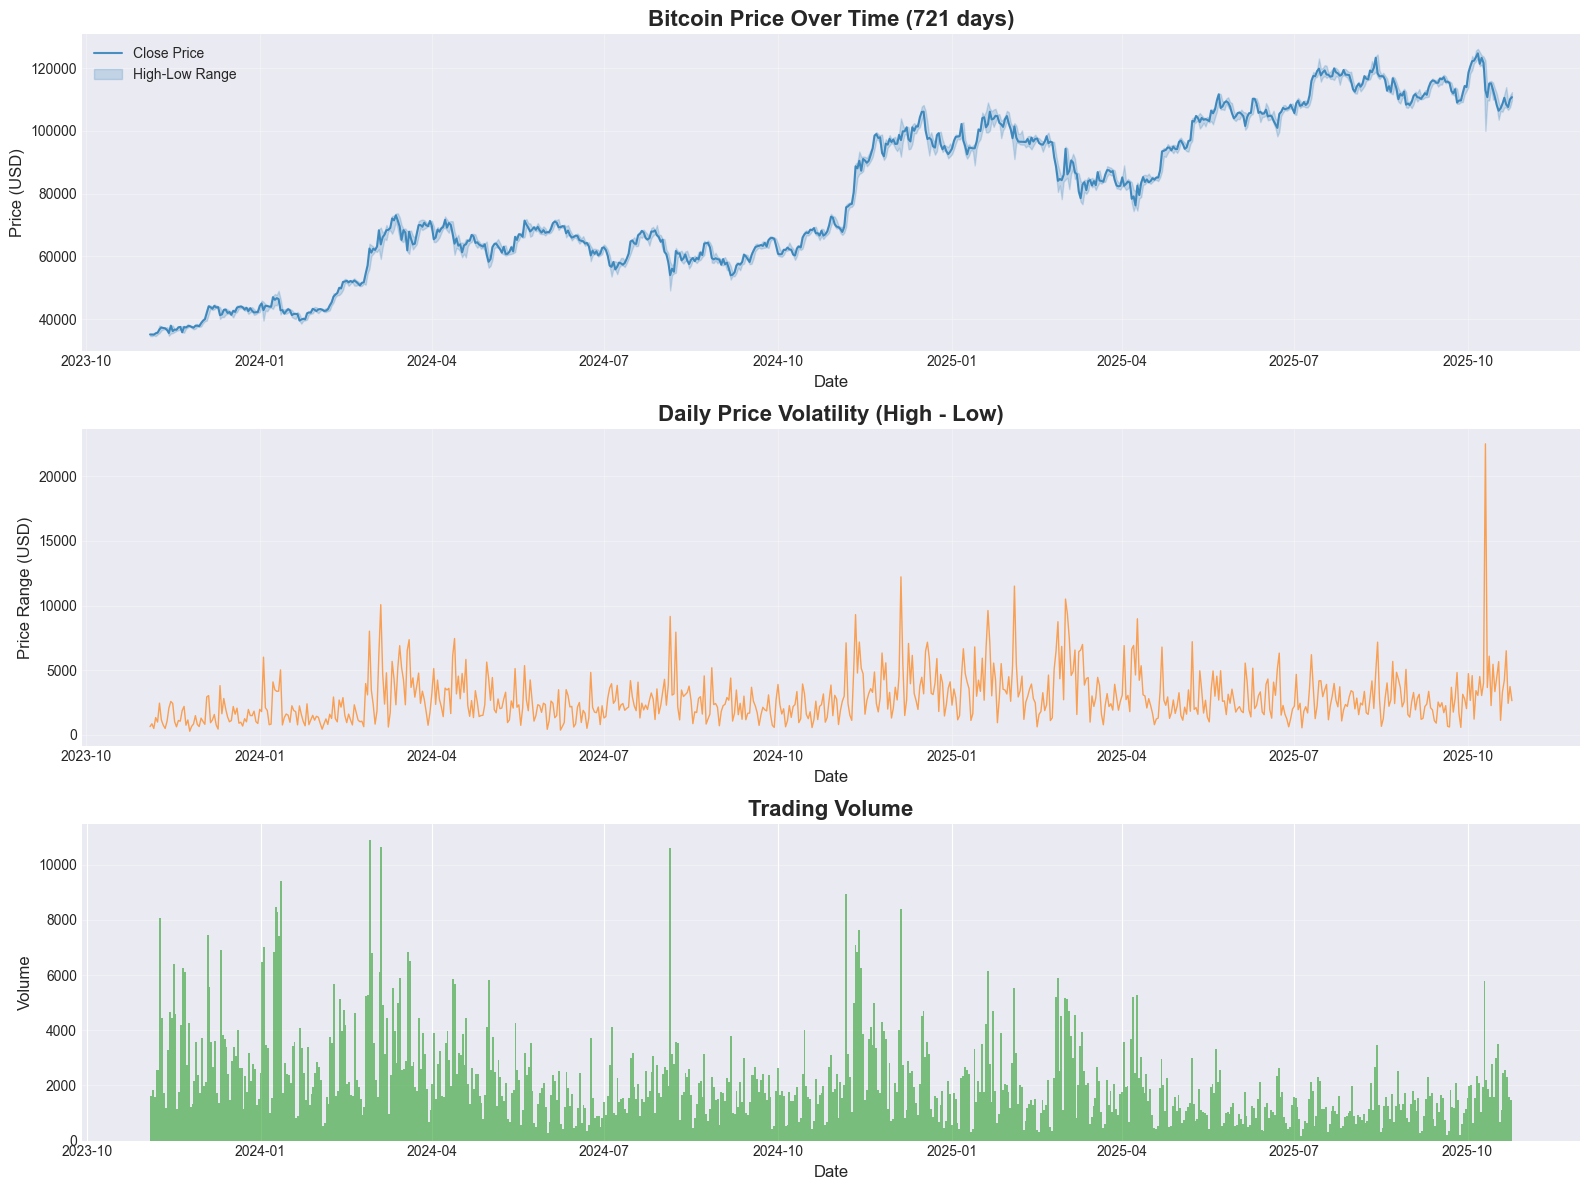


Price Statistics:
  Minimum close: $35,028.60
  Maximum close: $124,766.50
  Average close: $79,233.48
  Median close:  $71,371.20
  Std deviation: $24,896.24


In [80]:
# Set up plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# Plot 1: Close Price
axes[0].plot(bitcoin_df['timestamp'], bitcoin_df['close'], linewidth=1.5, color='#1f77b4', alpha=0.8)
axes[0].fill_between(bitcoin_df['timestamp'], bitcoin_df['low'], bitcoin_df['high'], alpha=0.2, color='#1f77b4')
axes[0].set_title(f'Bitcoin Price Over Time ({len(bitcoin_df)} days)', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Date', fontsize=12)
axes[0].set_ylabel('Price (USD)', fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].legend(['Close Price', 'High-Low Range'], loc='upper left')

# Plot 2: Daily Price Range (High - Low)
bitcoin_df['daily_range'] = bitcoin_df['high'] - bitcoin_df['low']
axes[1].plot(bitcoin_df['timestamp'], bitcoin_df['daily_range'], linewidth=1, color='#ff7f0e', alpha=0.7)
axes[1].set_title('Daily Price Volatility (High - Low)', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Date', fontsize=12)
axes[1].set_ylabel('Price Range (USD)', fontsize=12)
axes[1].grid(True, alpha=0.3)

# Plot 3: Volume (if available)
if bitcoin_df['volume'].notna().any():
    axes[2].bar(bitcoin_df['timestamp'], bitcoin_df['volume'], width=1, color='#2ca02c', alpha=0.6)
    axes[2].set_title('Trading Volume', fontsize=16, fontweight='bold')
    axes[2].set_xlabel('Date', fontsize=12)
    axes[2].set_ylabel('Volume', fontsize=12)
    axes[2].grid(True, alpha=0.3, axis='y')
else:
    axes[2].text(0.5, 0.5, 'Volume data not available', 
                 horizontalalignment='center', verticalalignment='center',
                 transform=axes[2].transAxes, fontsize=14)
    axes[2].set_title('Trading Volume (N/A)', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nPrice Statistics:")
print(f"  Minimum close: ${bitcoin_df['close'].min():,.2f}")
print(f"  Maximum close: ${bitcoin_df['close'].max():,.2f}")
print(f"  Average close: ${bitcoin_df['close'].mean():,.2f}")
print(f"  Median close:  ${bitcoin_df['close'].median():,.2f}")
print(f"  Std deviation: ${bitcoin_df['close'].std():,.2f}")

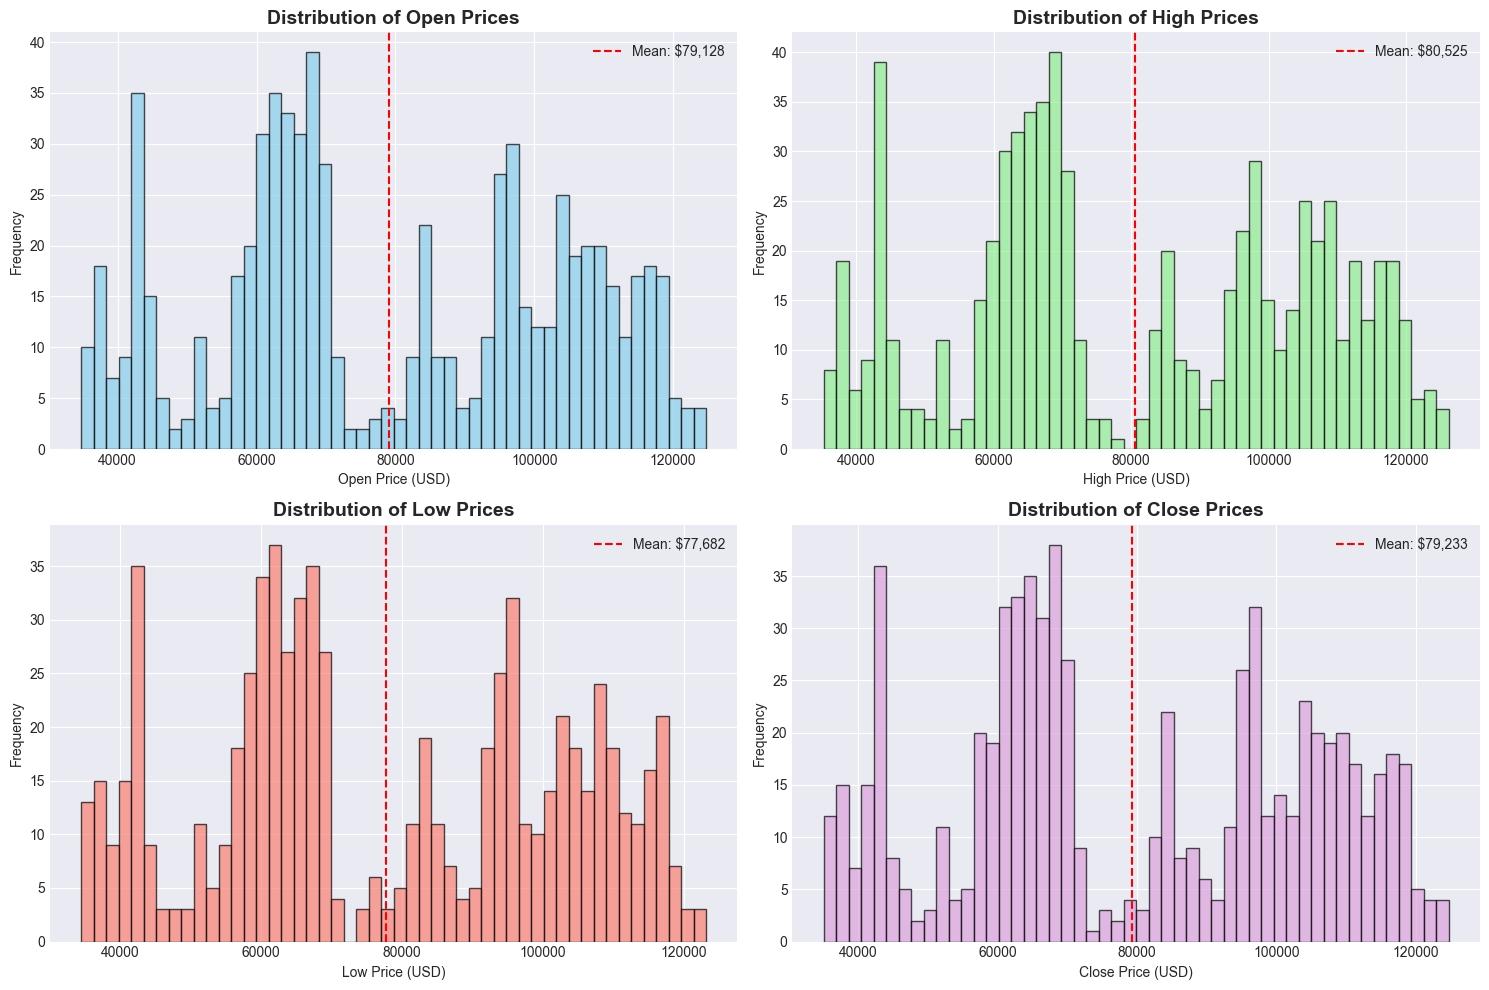

In [81]:
# Price distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].hist(bitcoin_df['open'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Distribution of Open Prices', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Open Price (USD)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(bitcoin_df['open'].mean(), color='red', linestyle='--', label=f'Mean: ${bitcoin_df["open"].mean():,.0f}')
axes[0, 0].legend()

axes[0, 1].hist(bitcoin_df['high'], bins=50, color='lightgreen', edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Distribution of High Prices', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('High Price (USD)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(bitcoin_df['high'].mean(), color='red', linestyle='--', label=f'Mean: ${bitcoin_df["high"].mean():,.0f}')
axes[0, 1].legend()

axes[1, 0].hist(bitcoin_df['low'], bins=50, color='salmon', edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Distribution of Low Prices', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Low Price (USD)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].axvline(bitcoin_df['low'].mean(), color='red', linestyle='--', label=f'Mean: ${bitcoin_df["low"].mean():,.0f}')
axes[1, 0].legend()

axes[1, 1].hist(bitcoin_df['close'], bins=50, color='plum', edgecolor='black', alpha=0.7)
axes[1, 1].set_title('Distribution of Close Prices', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Close Price (USD)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].axvline(bitcoin_df['close'].mean(), color='red', linestyle='--', label=f'Mean: ${bitcoin_df["close"].mean():,.0f}')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

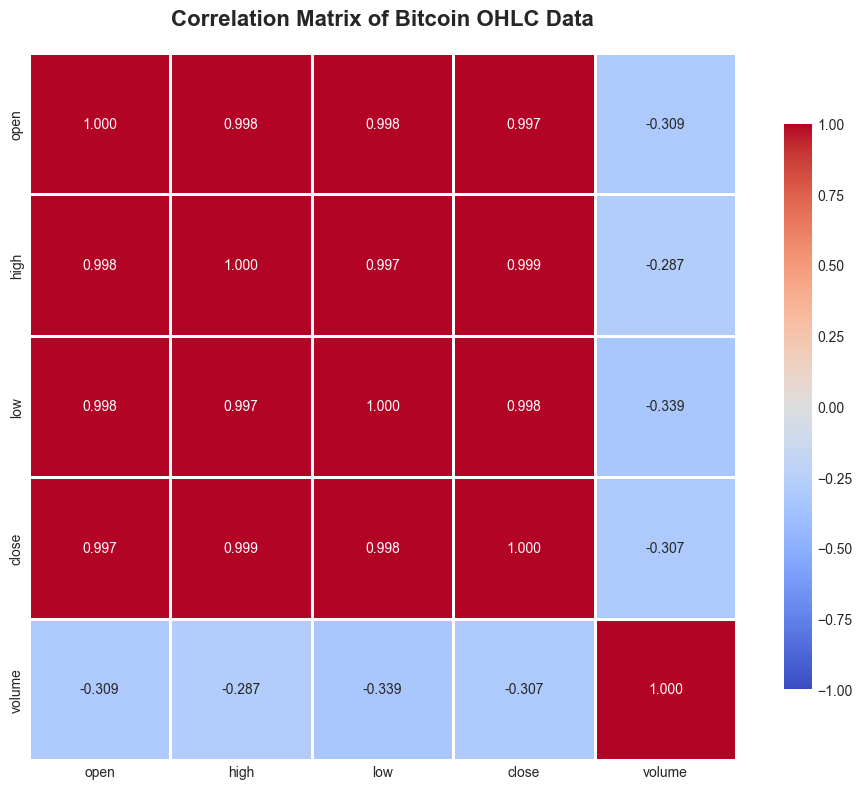

In [82]:
# Correlation matrix
correlation_cols = ['open', 'high', 'low', 'close']
if bitcoin_df['volume'].notna().any():
    correlation_cols.append('volume')

correlation_matrix = bitcoin_df[correlation_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, fmt='.3f',
            vmin=-1, vmax=1)
plt.title('Correlation Matrix of Bitcoin OHLC Data', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

## 8. Check for Data Completeness

In [83]:
# Check for gaps in time series
bitcoin_df['date'] = bitcoin_df['timestamp'].dt.date
date_range = pd.date_range(start=bitcoin_df['timestamp'].min(), 
                           end=bitcoin_df['timestamp'].max(), 
                           freq='D')

missing_dates = set(date_range.date) - set(bitcoin_df['date'])

print("="*70)
print("TIME SERIES COMPLETENESS CHECK")
print("="*70)
print(f"Expected number of days: {len(date_range)}")
print(f"Actual number of days:   {len(bitcoin_df)}")
print(f"Missing days:            {len(missing_dates)}")
print(f"Completeness:            {len(bitcoin_df)/len(date_range)*100:.2f}%")

if len(missing_dates) > 0:
    print(f"\n⚠️  First 10 missing dates:")
    for date in sorted(list(missing_dates))[:10]:
        print(f"   {date}")
else:
    print("\n✓ Perfect! No missing dates in the time series!")

TIME SERIES COMPLETENESS CHECK
Expected number of days: 721
Actual number of days:   721
Missing days:            0
Completeness:            100.00%

✓ Perfect! No missing dates in the time series!


## 9. Save the Data

In [84]:
import os

# Create data directory if it doesn't exist
os.makedirs('../data/raw', exist_ok=True)

# Save to CSV
output_csv = '../data/raw/bitcoin_2years_daily.csv'
bitcoin_df.to_csv(output_csv, index=False)
file_size_csv = os.path.getsize(output_csv) / 1024  # KB
print(f"✓ Data saved to: {output_csv}")
print(f"  File size: {file_size_csv:.2f} KB")

# Save to Parquet
output_parquet = '../data/raw/bitcoin_2years_daily.parquet'
bitcoin_df.to_parquet(output_parquet, index=False)
file_size_parquet = os.path.getsize(output_parquet) / 1024  # KB
print(f"✓ Data saved to: {output_parquet}")
print(f"  File size: {file_size_parquet:.2f} KB")

print(f"\n{'='*70}")
print("✓ DATA COLLECTION COMPLETE!")
print(f"{'='*70}")
print(f"Records saved: {len(bitcoin_df)}")
print(f"Date range: {bitcoin_df['timestamp'].min().date()} to {bitcoin_df['timestamp'].max().date()}")
print(f"Days covered: {(bitcoin_df['timestamp'].max() - bitcoin_df['timestamp'].min()).days}")

✓ Data saved to: ../data/raw/bitcoin_2years_daily.csv
  File size: 96.62 KB
✓ Data saved to: ../data/raw/bitcoin_2years_daily.parquet
  File size: 70.97 KB

✓ DATA COLLECTION COMPLETE!
Records saved: 721
Date range: 2023-11-04 to 2025-10-24
Days covered: 720
